# Probando!!!

In [1]:
import medmnist, torch
from medmnist import INFO, Evaluator
from medmnist.dataset import PneumoniaMNIST
import torch.utils.data as data

import os, sys
project_dir = os.path.join(os.getcwd(),'..')
if project_dir not in sys.path:
    sys.path.append(project_dir)


print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.2.2 @ https://github.com/MedMNIST/MedMNIST/


Using downloaded and verified file: data/pneumoniamnist.npz
AnomalyPneumoniaMNIST Dataset (Number of samples: 1516, Number of known anomalies: 242, Number of unknown anomalies: 60)


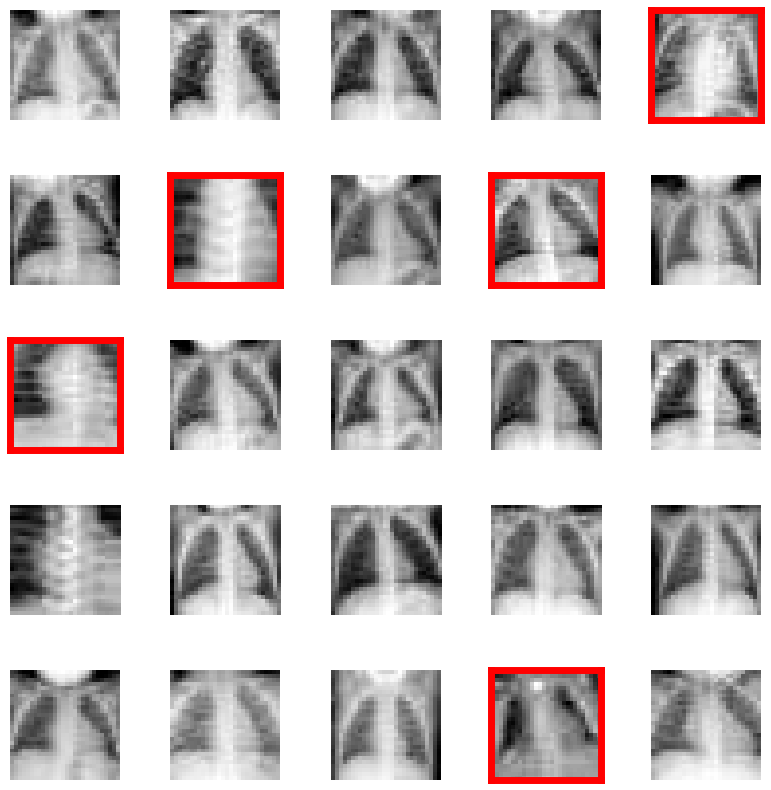

In [2]:
from dataset import AnomalyPneumoniaMNIST
from matplotlib import pyplot as plt
from torchvision import transforms

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5]),
])

# Load the dataset
seed = None
train_dataset = AnomalyPneumoniaMNIST('data/', download=True, transform=data_transform, n_normal_samples=-1, known_anomalies=0.2, pollution=0.05, seed=seed)
print(train_dataset)

train_dataset.montage(5, 5, seed)
plt.show()

In [3]:
# Generate the test dataset and the loaders
BATCH_SIZE = 128
test_dataset = PneumoniaMNIST(split='test', transform=data_transform, download=True, root='data/')

train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=4*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: data/pneumoniamnist.npz


# Model

In [4]:
from ADeLEn.model import ADeLEn
from torch.nn.functional import mse_loss
from VAE.loss import SGVBL

# model = ADeLEn((28, 28), [1, 12, 32], [1024, 512, 128, 2], skip_connection=False) # Old implementation
model = ADeLEn((28, 28), [1, 12, 32], [512, 256, 32], bottleneck=2, skip_connection=False)
from torch.nn.functional import mse_loss
sgvbl = SGVBL(model, len(train_dataset), mle=mse_loss)

# Training

In [5]:
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.train()
n_epochs = 100


epoch_iterator = tqdm(
        range(n_epochs),
        leave=True,
        unit="epoch",
        postfix={"tls": "%.4f" % -1},
    )

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
for epoch in epoch_iterator:
    epoch_loss = 0.
    for x, y in train_loader:
        x = x.to(device) # GPU
        opt.zero_grad()
        x_hat = torch.tanh(model(x))
        loss = sgvbl(x, x_hat, y, 1)
        epoch_loss += loss.detach().item()

        loss.backward()
        opt.step()
    
    epoch_iterator.set_postfix(tls="%.3f" % (epoch_loss/len(train_loader)))

model = model.eval()

100%|██████████| 100/100 [01:02<00:00,  1.60epoch/s, tls=245.471]


# Result

In [7]:
import numpy as np
from matplotlib import pyplot as plt

def plot_latent(model, data, num_batches=100):
    model.eval()
    fig = plt.figure(figsize=(5,5))
    with torch.no_grad():
        for i, (x, y) in enumerate(data):
            x = x.to(device)
            z = model.bottleneck(model.encode_path(x))
            z = z.cpu().detach().numpy()
            y = y.cpu().detach().numpy()
            anomalies = np.where(y == 1)
            normal = np.where(y == 0)
            if i == 0:
                plt.scatter(z[normal, 0], z[normal, 1], c='r', alpha=.7, label='normal')
                plt.scatter(z[anomalies, 0], z[anomalies, 1], c='b', alpha=.7, label='anomalies')
            else:
                plt.scatter(z[normal, 0], z[normal, 1], c='r',alpha=.7)
                plt.scatter(z[anomalies, 0], z[anomalies, 1], c='b',alpha=.7)
           
            if i > num_batches:
                plt.legend()
                return
    plt.legend()
    return fig

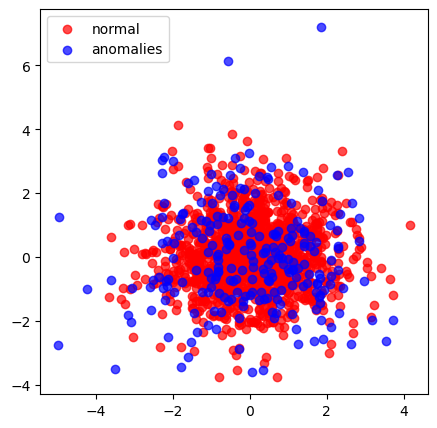

In [8]:
model.eval()
train_eval_loader = data.DataLoader(dataset=train_dataset, batch_size=4*BATCH_SIZE, shuffle=False)


# model.train()
plot_latent(model, train_eval_loader, num_batches=1)

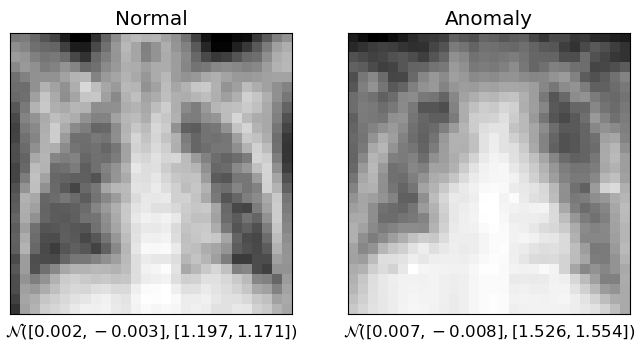

(tensor([[ 0.0020, -0.0031],
         [ 0.0068, -0.0078]]),
 tensor([[1.1971, 1.1707],
         [1.5260, 1.5539]]))

In [9]:
x, y = next(iter(train_loader))
x_0 = x[np.argwhere(y==0)[0].squeeze()[0]].unsqueeze(0)
x_1 = x[np.argwhere(y==1)[0].squeeze()[0]].unsqueeze(0)
x = torch.cat([x_0, x_1], dim=0)
# _ = model.bottleneck(model.encoder(x.to(device)))
_ = model(x.to(device))

# mu, sigma = model.bottleneck[1].anomaly_detector.mu.detach().cpu(), model.bottleneck[1].anomaly_detector.sigma.detach().cpu()
mu, sigma = model.bottleneck.mu.detach().cpu(), model.bottleneck.sigma.detach().cpu()

plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.title("Normal", fontsize='x-large')
plt.xlabel("$\mathcal{N}([%.3f, %.3f], [%.3f, %.3f])$" % (*mu[0].numpy().tolist(), *sigma[0].numpy().tolist()), fontsize='large')
plt.xticks([])
plt.yticks([])
plt.imshow(x[0][0], cmap='gray')
plt.subplot(1,2,2)
plt.title("Anomaly", fontsize='x-large')
plt.xlabel("$\mathcal{N}([%.3f, %.3f], [%.3f, %.3f])$" % (*mu[1].numpy().tolist(), *sigma[1].numpy().tolist()), fontsize='large')
plt.xticks([])
plt.yticks([])
plt.imshow(x[1][0], cmap='gray')

plt.savefig('figures/medmnist_test.pdf', bbox_inches='tight')
plt.show()

x = torch.cat([x_0, x_1])
# z = model.bottleneck(model.encoder(x.to(device))).detach().cpu()
mu, sigma

(tensor(0.0504, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(0.0649, device='cuda:0', grad_fn=<MseLossBackward0>))

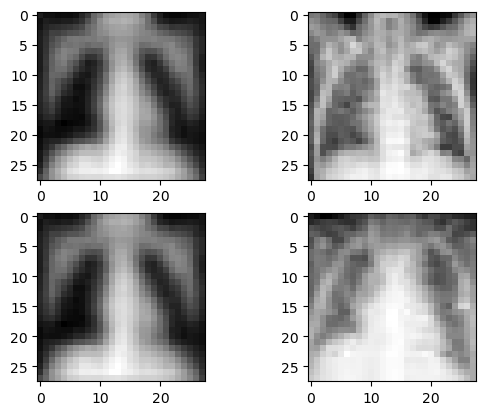

In [10]:
x_hat = model(x_0.to(device))
plt.subplot(2,2,1)
plt.imshow(x_hat[0,0].detach().cpu(), cmap='gray')
plt.subplot(2,2,2)
plt.imshow(x_0[0,0], cmap='gray')

x_hat = model(x_1.to(device))
plt.subplot(2,2,3)
plt.imshow(x_hat[0,0].detach().cpu(), cmap='gray')
plt.subplot(2,2,4)
plt.imshow(x_1[0,0], cmap='gray')

mse_loss(x_hat, x_0.to(device)), mse_loss(x_hat, x_1.to(device))


In [11]:
model

ADeLEn(
  (encode_path): Sequential(
    (0): ConvEncoder(
      (encode_path): Sequential(
        (0): Sequential(
          (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Dropout2d(p=0.5, inplace=False)
          (3): ReLU()
          (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        )
        (1): Sequential(
          (0): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Dropout2d(p=0.5, inplace=False)
          (3): ReLU()
          (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        )
      )
    )
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): LinearEncoder(
      (encode_path): Sequential(
        (0): Sequential(
          (0): Linear(in_featur

In [12]:
import numpy as np
# def plot_reconstructed(autoencoder, r0=(-10, 10), r1=(-10, 10), n=12):
#     w = 28
#     img = np.zeros((n*w, n*w))

#     bottleneck, unflatten = autoencoder.bottleneck[1:]
#     bottleneck = bottleneck.bottleneck[2]

#     for i, y in enumerate(np.linspace(*r1, n)):
#         for j, x in enumerate(np.linspace(*r0, n)):
#             z = torch.Tensor([[x, y]]).to(device)
#             x_hat = torch.tanh(autoencoder.decoder(unflatten(bottleneck(z)))) # ADeLEn
#             # x_hat = torch.tanh(autoencoder.decoder(z))
#             x_hat = x_hat.reshape(w, w).to('cpu').detach().numpy()
#             img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    
#     plt.xlabel('$\mathcal{N}(0, \sigma_1)$', fontsize='x-large')
#     plt.ylabel('$\mathcal{N}(0, \sigma_2)$', fontsize='x-large')
#     plt.imshow(img, extent=[*r0, *r1], cmap='viridis')

def plot_reconstructed(model, r0=(-10, 10), r1=(-10, 10), n=12):
    w = 28
    img = np.zeros((n*w, n*w))

    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = torch.tanh(model.decode_path(z)) # ADeLEn
            # x_hat = torch.tanh(autoencoder.decoder(z))
            x_hat = x_hat.reshape(w, w).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    
    plt.xlabel('$\mathcal{N}(0, \sigma_1)$', fontsize='x-large')
    plt.ylabel('$\mathcal{N}(0, \sigma_2)$', fontsize='x-large')
    plt.imshow(img, extent=[*r0, *r1], cmap='viridis')

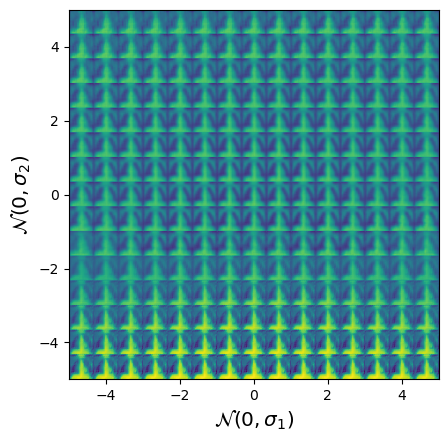

In [13]:
model.eval()
plot_reconstructed(model, r0=(-5, 5), r1=(-5, 5), n=15)

In [14]:
model

ADeLEn(
  (encode_path): Sequential(
    (0): ConvEncoder(
      (encode_path): Sequential(
        (0): Sequential(
          (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Dropout2d(p=0.5, inplace=False)
          (3): ReLU()
          (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        )
        (1): Sequential(
          (0): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Dropout2d(p=0.5, inplace=False)
          (3): ReLU()
          (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        )
      )
    )
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): LinearEncoder(
      (encode_path): Sequential(
        (0): Sequential(
          (0): Linear(in_featur

In [15]:
x_test, y_test = next(iter(test_loader))
model.eval()
print(x_test.shape)
# x_0 = x_test[np.argwhere(y_test==0)[0].squeeze()[:100]]
# x_1 = x_test[np.argwhere(y_test==1)[0].squeeze()[:100]]
x_0 = x_test[np.argwhere(y_test==0)[0].squeeze()]
x_1 = x_test[np.argwhere(y_test==1)[0].squeeze()]

x = torch.cat([x_0, x_1], dim=0)
y = torch.cat([torch.zeros(len(x_0)), torch.ones(len(x_1))])

x_enc = model.encode_path(x.to(device))
# x_enc, sk = model.encoder(x.to(device))
# flatten, bottleneck, unflatten = model.bottleneck[:3]
# bottleneck = bottleneck.bottleneck[:2]
x_bottleneck = model.bottleneck(x_enc)

anomaly_detector = model.bottleneck
sigma = anomaly_detector.sigma.detach().cpu()
sigma.mean(axis=0), sigma.std(axis=0)

torch.Size([512, 1, 28, 28])


(tensor([1.3543, 1.3730]), tensor([0.1733, 0.1875]))

In [16]:
model.bottleneck

AnomalyDetector(in_features=32, out_features=2, bias=True)

In [18]:
sigma[:100].mean(axis=0), sigma[100:].mean(axis=0)

(tensor([1.2208, 1.2199]), tensor([1.3867, 1.4102]))

In [52]:
x_test, y_test = list(zip(*[(_x, _y) for _x, _y in test_dataset]))
x_test = torch.tensor(np.stack(x_test))
y_test = torch.tensor(y_test).flatten()

_ = model(x_test.to(device))

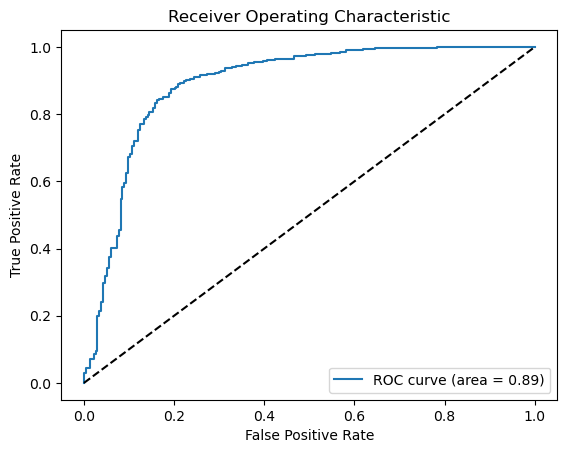

In [54]:
normalize = np.log(2*np.pi*np.e)
y_score = .5*(normalize + torch.log(model.bottleneck.sigma).sum(axis=1).detach().cpu().numpy())

from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [57]:
y_score[torch.argwhere(y_test==0).squeeze()]
y_score[torch.argwhere(y_test==1).squeeze()]

(390,)

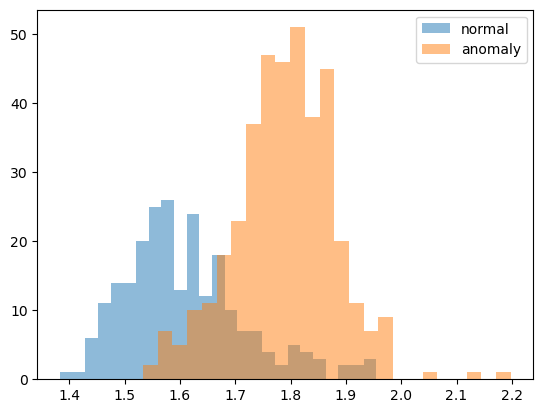

In [59]:
plt.hist(y_score[torch.argwhere(y_test==0).squeeze()], bins=25, alpha=.5, label='normal')
plt.hist(y_score[torch.argwhere(y_test==1).squeeze()], bins=25, alpha=.5, label='anomaly')
plt.legend()
plt.show()

In [36]:
y_score.shape

(512,)

In [29]:
# Calcular la diferencia entre TPR y FPR para cada umbral
differences = tpr - fpr

# Encontrar el índice del umbral que maximiza la diferencia
optimal_threshold_index = np.argmax(differences)

# Obtener el umbral óptimo
optimal_threshold = thresholds[optimal_threshold_index]

print("Optimal threshold:", optimal_threshold)

Optimal threshold: 1.6906716
